### 0. 환경설정

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

### 1. 데이터 가져오기

In [2]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### 2. 데이터 전처리 및 EDA

In [6]:
# 결측값 확인
print(movies_df.isnull().sum())
print(ratings_df.isnull().sum())
print(tags_df.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [7]:
# 장르 데이터 분리 및 정리
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))

##### 2.1. 연대별 영화 수 : 몇년대에 영화가 붐이었는가?

In [8]:
movies_df['year'] = movies_df['title'].str.extract('(\(\d\d\d\d\))') 
movies_df['year'] = movies_df['year'].fillna('NaN')
movies_df['year'] = movies_df['year'].apply(lambda x: x.replace('(','').replace(')',''))
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


In [9]:
movies_df["year_term"] = movies_df["year"].apply(lambda x : x[-4 :-1] + "0")
movies_df.head()

,movieId,title,genres,year,year_term
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1990
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,1990
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,1990
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,1990
4,5,Father of the Bride Part II (1995),[Comedy],1995,1990


In [10]:
# title column에서 연도가 나오지 않은 영화들은 제거
movies_df = movies_df[movies_df['year_term'] != 'Na0']

In [11]:
# 연대별 영화의 수
movie_year_term = movies_df["year_term"].value_counts().sort_index()
movie_year_term

1900       3
1910       7
1920      37
1930     136
1940     197
1950     279
1960     401
1970     500
1980    1177
1990    2212
2000    2849
2010    1931
Name: year_term, dtype: int64

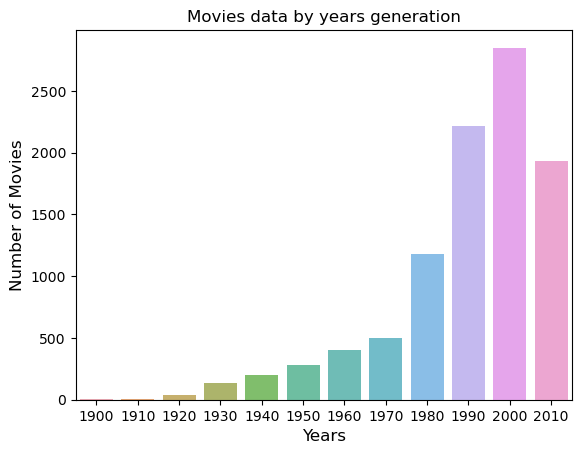

In [12]:
sns.barplot(x=movie_year_term.index, y=movie_year_term.values, alpha=0.8)
plt.title('Movies data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

##### 2000년대에 영화 붐이었던 것을 알 수 있음.

##### 2.2. 영화 장르별 개수 : 가장 많이 등장한 장르는 무엇인가?

In [13]:
# 가장 많이 사용된 장르의 조합을 출력
movies_df['genres'].value_counts()[:10]

[Drama]                     1052
[Comedy]                     946
[Comedy, Drama]              435
[Comedy, Romance]            363
[Drama, Romance]             349
[Documentary]                339
[Comedy, Drama, Romance]     276
[Horror]                     167
[Drama, Thriller]            167
[Horror, Thriller]           135
Name: genres, dtype: int64

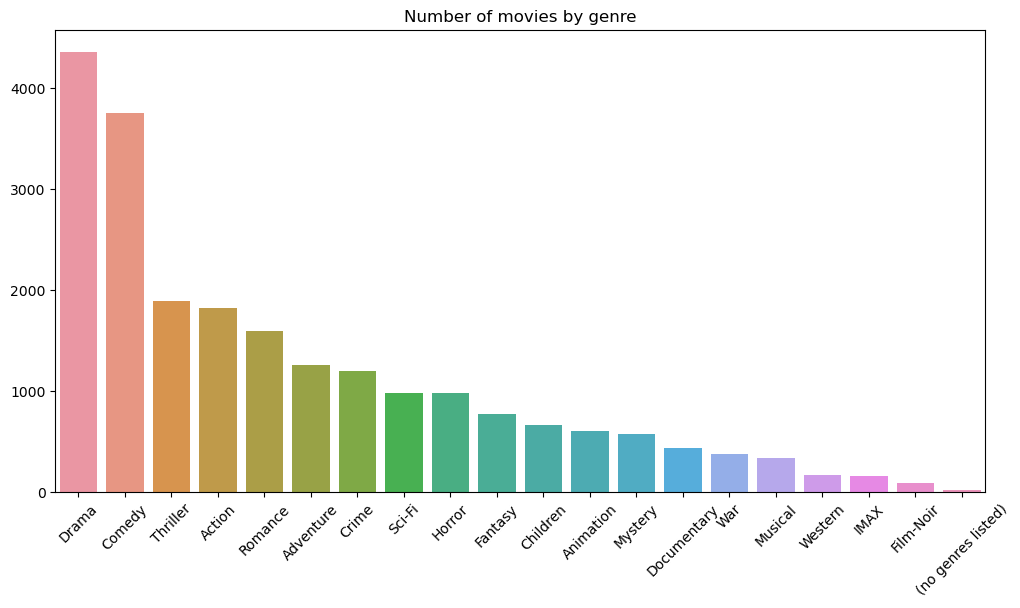

In [14]:
genre_count = {}
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
genre_count = pd.Series(genre_count)
genre_count.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_count.index, y=genre_count.values)
plt.xticks(rotation=45)
plt.title("Number of movies by genre")
plt.show()

##### 가장 많이 등장한 장르는 드라마라는 것을 알 수 있음. 드라마는 대부분의 사람들이 흔히 접하는 크게 호불호가 없는 장르이기에 위와 같은 결과가 나온 것 같음.

##### 2.3. 평점 데이터 탐색 : 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화는 무엇인가?

In [15]:
# 영화별 평균 평점을 탐색
movie_grouped_rating_info = ratings_df.groupby("movieId")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']
movie_grouped_rating_info.head()

,rated_count,rating_mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [16]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력
merged_data = movie_grouped_rating_info.merge(movies_df, on=['movieId'], how='left')
top_10_movies = merged_data[merged_data['rated_count'] > 100].nlargest(10, 'rating_mean')[['rating_mean', 'title']]
print(top_10_movies)

      rating_mean                                      title
277      4.429022           Shawshank Redemption, The (1994)
659      4.289062                      Godfather, The (1972)
2224     4.272936                          Fight Club (1999)
921      4.259690             Godfather: Part II, The (1974)
6298     4.252336                       Departed, The (2006)
913      4.250000                          Goodfellas (1990)
6693     4.238255                    Dark Knight, The (2008)
46       4.237745                 Usual Suspects, The (1995)
898      4.232394                 Princess Bride, The (1987)
224      4.231076  Star Wars: Episode IV - A New Hope (1977)


##### 2.4. 태그 데이터 탐색 : 가장 많이 태그되는 문구는 무엇인가?

In [17]:
tags_df['tag'] = [re.sub('[^A-Za-z]', ' ', s).lower() for s in tags_df['tag']]

In [18]:
stop_words = set(stopwords.words('english'))
tag_copy = tags_df.copy()
result = []
for sentence in tags_df.tag:
        words = [word for word in word_tokenize(sentence) if word not in stop_words]
        result.append(words)
tag_copy.tag = result

In [19]:
vect_tag = CountVectorizer(max_features = 1000, stop_words = 'english')
corpus_tag = sum(tag_copy['tag'], []) 
ct_tag = vect_tag.fit_transform(corpus_tag)
count_tag = pd.DataFrame({'word': vect_tag.get_feature_names_out(),
                          'count': ct_tag.sum(axis=0).flat})
count_tag.sort_values('count', ascending = False).head()

,word,count
445,netflix,134
586,queue,131
145,comedy,64
172,dark,47
48,atmospheric,41


<function matplotlib.pyplot.show(close=None, block=None)>

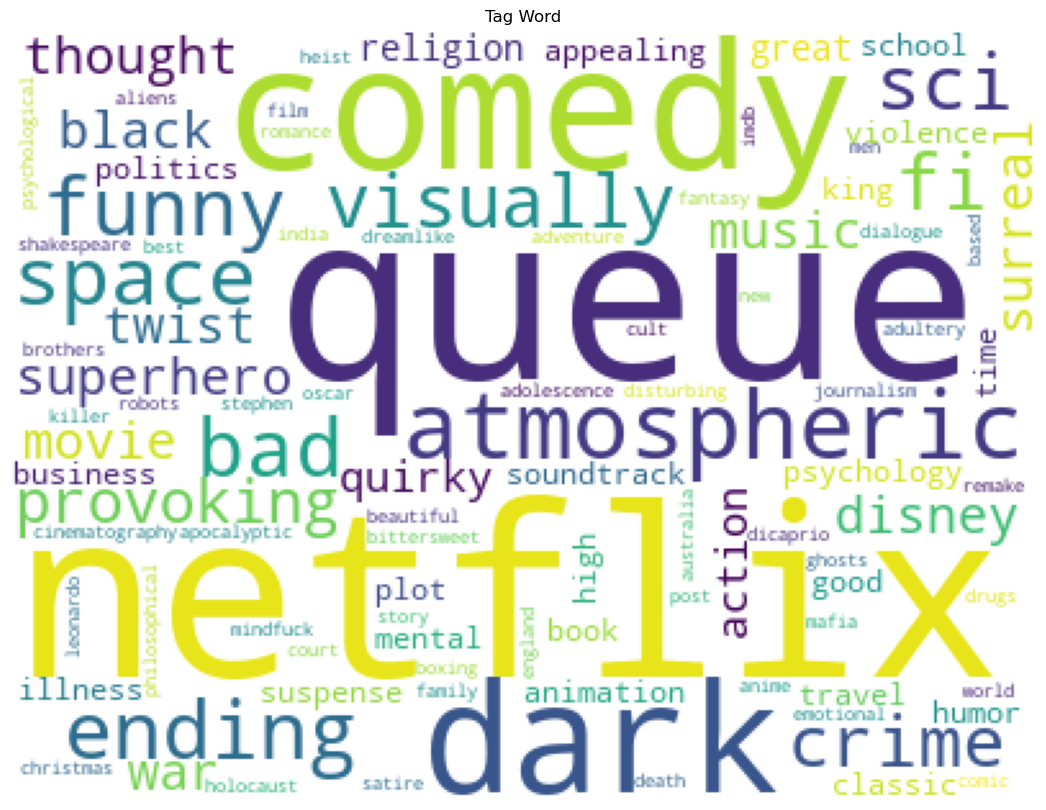

In [20]:
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)
plt.figure(figsize = (15,10))
plt.title('Tag Word')
count_dic = dict(zip(count_tag['word'], count_tag['count']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)
plt.show

##### 가장 많이 태그되는 문구는 netflix임을 알 수 있음.

##### 2.5. 유저 데이터 탐색 : 유저별로 평가한 영화 개수, 평균 영화 점수, 영화 점수의 편차는 어떠한가?

In [21]:
# 유저별 영화 평가를 탐색
user_grouped_rating_info = ratings_df.groupby('userId')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
userId,,,
1,232,4.366379,0.800048
2,29,3.948276,0.805615
3,39,2.435897,2.090642
4,216,3.555556,1.314204
5,44,3.636364,0.990441


In [22]:
# Surprise library 사용
from surprise import Dataset
from surprise import SVD
from surprise import SVDpp
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split

In [23]:
data = Dataset.load_builtin('ml-100k')
train_data, test_data = train_test_split(data, test_size = .25)

### 3. Memory based CF

##### 3.1. KNNBasic

In [24]:
knn_basic = KNNBasic()
knn_basic.fit(train_data)
knn_basic_prediction = knn_basic.test(test_data)

print(f'prediction type: {type(knn_basic)} size: {len(knn_basic_prediction)}')
print('prediction(5)')
[print(i) for i in knn_basic_prediction[:5]]

print(f'RMSE: {accuracy.rmse(knn_basic_prediction)}')

Computing the msd similarity matrix...
Done computing similarity matrix.
prediction type: <class 'surprise.prediction_algorithms.knns.KNNBasic'> size: 25000
prediction(5)
user: 533        item: 71         r_ui = 4.00   est = 3.73   {'actual_k': 40, 'was_impossible': False}
user: 70         item: 202        r_ui = 4.00   est = 3.70   {'actual_k': 40, 'was_impossible': False}
user: 256        item: 121        r_ui = 5.00   est = 3.68   {'actual_k': 40, 'was_impossible': False}
user: 90         item: 241        r_ui = 5.00   est = 3.73   {'actual_k': 40, 'was_impossible': False}
user: 22         item: 684        r_ui = 3.00   est = 3.65   {'actual_k': 40, 'was_impossible': False}
RMSE: 0.9814
RMSE: 0.9813627619589111


##### 3.2. KNNwithMeans 

In [25]:
knn_means = KNNWithMeans()
knn_means.fit(train_data)
knn_means_prediction = knn_means.test(test_data)

print(f'prediction type: {type(knn_means)} size: {len(knn_means_prediction)}')
print('prediction(5)')
[print(i) for i in knn_means_prediction[:5]]

print(f'RMSE: {accuracy.rmse(knn_means_prediction)}')

Computing the msd similarity matrix...
Done computing similarity matrix.
prediction type: <class 'surprise.prediction_algorithms.knns.KNNWithMeans'> size: 25000
prediction(5)
user: 533        item: 71         r_ui = 4.00   est = 3.47   {'actual_k': 40, 'was_impossible': False}
user: 70         item: 202        r_ui = 4.00   est = 3.49   {'actual_k': 40, 'was_impossible': False}
user: 256        item: 121        r_ui = 5.00   est = 3.84   {'actual_k': 40, 'was_impossible': False}
user: 90         item: 241        r_ui = 5.00   est = 4.21   {'actual_k': 40, 'was_impossible': False}
user: 22         item: 684        r_ui = 3.00   est = 3.46   {'actual_k': 40, 'was_impossible': False}
RMSE: 0.9514
RMSE: 0.9513525039153986


### 4. Model based CF

##### 4.1. SVD

In [26]:
svd = SVD()
svd.fit(train_data)
svd_prediction = svd.test(test_data)
print('prediction type : ', type(svd_prediction), 'size : ', len(svd_prediction))
print('prediction(5)')
[print(i) for i in svd_prediction[:5]]

print(f'RMSE: {accuracy.rmse(svd_prediction)}')

prediction type :  <class 'list'> size :  25000
prediction(5)
user: 533        item: 71         r_ui = 4.00   est = 3.61   {'was_impossible': False}
user: 70         item: 202        r_ui = 4.00   est = 3.61   {'was_impossible': False}
user: 256        item: 121        r_ui = 5.00   est = 4.36   {'was_impossible': False}
user: 90         item: 241        r_ui = 5.00   est = 3.74   {'was_impossible': False}
user: 22         item: 684        r_ui = 3.00   est = 3.98   {'was_impossible': False}
RMSE: 0.9439
RMSE: 0.9439363727159601
